# Setting up

*pandas, numpy, matplotlib* - The analyst's bread and butter

*semopy* - Package for structural equation modeling

The docs and tutorial available at https://semopy.com/tutorial.html can help get familiar with semopy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from semopy import Model
from semopy import semplot
from semopy import calc_stats
from semopy.efa import explore_cfa_model

import statsmodels.api as sm

Functions to calculate the middle 50 on our data:

In [2]:
def q25(x):
    return x.quantile(0.25)
def q75(x):
    return x.quantile(0.75)

We'll be looking at personality data.
Description available here: https://rdrr.io/cran/psych/man/bfi.html

Basically, the data is survey responses and some demographic information about the respondents.

In [3]:
data = pd.read_csv('data/bfi.csv')

data.drop('Unnamed: 0', axis = 1, inplace = True)

Some items are encoded backwards during data collection. We can reverse them so an increase in each item is associated with an increase in its related latent variable.

For example, questions asking, on a scale of 1-6, "Are you generally happy?" and "Are you generally sad?" are getting at the same thing (e.g. well-being), but encoded responses would be negatively correlated. Reversing them ensures that the underlying construct they measure will move up as respondents increase their responses.

In [4]:
data.iloc[:,[0,8,9,10,11,21,24]] = 7 - data.iloc[:,[0,8,9,10,11,21,24]]

In [5]:
data.agg([min, max])

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N4,N5,O1,O2,O3,O4,O5,gender,education,age
min,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1,1.0,1.0,1.0,1,1.0,3
max,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,...,6.0,6.0,6.0,6,6.0,6.0,6.0,2,5.0,86


In [6]:
data.describe()

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,N4,N5,O1,O2,O3,O4,O5,gender,education,age
count,2784.000000,2773.00000,2774.000000,2781.000000,2784.000000,2779.000000,2776.000000,2780.000000,2774.000000,2784.000000,...,2764.000000,2771.000000,2778.000000,2800.000000,2772.000000,2786.000000,2780.000000,2800.000000,2577.000000,2800.000000
mean,4.586566,4.80238,4.603821,4.699748,4.560345,4.502339,4.369957,4.303957,4.446647,3.703305,...,3.185601,2.969686,4.816055,4.286786,4.438312,4.892319,4.510432,1.671786,3.190144,28.782143
std,1.407737,1.17202,1.301834,1.479633,1.258512,1.241347,1.318347,1.288552,1.375118,1.628542,...,1.569685,1.618647,1.129530,1.565152,1.220901,1.221250,1.327959,0.469647,1.107714,11.127555
min,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,2.000000,...,2.000000,2.000000,4.000000,3.000000,4.000000,4.000000,4.000000,1.000000,3.000000,20.000000
50%,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,...,3.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,3.000000,26.000000
75%,6.000000,6.00000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,5.000000,...,4.000000,4.000000,6.000000,6.000000,5.000000,6.000000,6.000000,2.000000,4.000000,35.000000
max,6.000000,6.00000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,2.000000,5.000000,86.000000


It looks like each item is encoded on a 1-6 scale of agreement. The subjects in the study were identified as male and female, with education encoded for 5 different levels, and ages varying from 3 to 86.

We can clean the gender and education columns to make them more interpretable, and bin age for some aggregate analysis.

In [10]:
data.loc[data.gender.notnull(), 'gender'] = data.loc[data.gender.notnull(), 'gender'] - 1

gender_dict = {0 : 'Male', 1 : 'Female'}

education_dict = {1 : 'Some high school', 2 : 'High school graduate',
                  3 : 'Some college', 4 : 'College graduate', 5 : 'Graduate degree'}

data['gender_2'] = None
data.loc[:, 'gender_2'] = data.gender.map(gender_dict)

data['education_2'] = None
data.loc[:, 'education_2'] = data.education.map(education_dict)
data.education_2 = pd.Categorical(data.education_2, 
                                categories=[ 'Some high school', 'High school graduate', 'Some college',
                                           'College graduate', 'Graduate degree'],
                                ordered=True)

data['age_bin'] = pd.cut(data['age'], [-1, 20, 30,40, 200])

# Structural equation modeling (SEM)

The data collected captures personality as it the relates to the five-factor model of personality.

An outline of the factors is available here: https://www.britannica.com/science/five-factor-model-of-personality

1. *Agreeableness* is captured in an individual's empathy, kindness, and sympathy.
2. *Conscientiousness* is captured in an individual’s sense of duty / responsibility.
3. *Extraversion* is captured in an individual’s assertiveness, energy, and sociability.
4. *Neuroticism* is captured in an individual’s emotional instability.
5. *Openness* is captured in an individual’s inquisitiveness, thoughtfulness, and propensity for intellectually challenging tasks.

Together, the continuums of these factors are thought to capture a lot of individual differences observed in people's personalities.

Each item adds value to understanding where an individual may fall on each of these continuums. By specifying a model to capture the latent variables (i.e. the factors) of personality, we can get insight into the personality of each subject, based on item responses.

### Model specification

Subject matter experts (SMEs) can often contribute insight into latent variables that may exist and which items will be used to capture these latent variables. In this case, psychologists understand which factors of personality each item is intended to measure, so we know how to specify our SEM.

In [11]:
desc = """
Agreeableness =~ A1 + A2 + A3 + A4 + A5
Conscientiousness =~ C1 + C2 + C3 + C4 + C5
Extraversion =~ E1 + E2 + E3 + E4 + E5
Neuroticism =~ N1 + N2 + N3 + N4 + N5
Openness =~ O1 + O2 + O3 + O4 + O5
"""

model = Model(desc)
model.fit(data)
ins = model.inspect()
ins[ins.op == '~']

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,A1,~,Agreeableness,1.000000,-,-,-
1,A2,~,Agreeableness,-1.584449,0.104878,-15.1076,0
2,A3,~,Agreeableness,-2.048896,0.131593,-15.57,0
3,A4,~,Agreeableness,-1.527063,0.109749,-13.9142,0
4,A5,~,Agreeableness,-1.836089,0.1195,-15.3648,0
5,C1,~,Conscientiousness,1.000000,-,-,-
6,C2,~,Conscientiousness,1.162861,0.0562428,20.6757,0
7,C3,~,Conscientiousness,1.041195,0.0530372,19.6314,0
8,C4,~,Conscientiousness,-1.426735,0.0639101,-22.3241,0
9,C5,~,Conscientiousness,-1.523567,0.0714087,-21.3359,0


The relationships between our latent variables and observed variables are quite strong!

### Model fit indices

In [12]:
calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,265,300,4715.596529,0.0,20253.27714,0.776949,0.767169,0.736417,0.767169,0.74749,0.077461,116.631717,472.874199,1.684142


Based on $\chi^2$, it seems the model fits well, since $p<.1$.

However, *CFI* and *RMSEA* indicate our latent variable specification may be off. Generally, *CFI* $> .9$ and *RMSEA* $< .06$ indicate acceptable fit.

### Exploratory factor analysis
As an exercise, let's see if semopy can identify a better set of underlying variables (which would conflict with theory and the guidance of SMEs).

In [13]:
data_exploratory = data.iloc[:,:25].dropna(how='any').copy()
print(explore_cfa_model(data_exploratory))

eta1 =~ E4 + A5 + E3 + E2 + A3 + A2 + E5 + E1 + O3 + A4 + O1 + N4 + A1 + O2
eta2 =~ N4 + N3 + N1 + N2 + C5 + N5 + C4 + E2 + O4 + O2 + C2
eta3 =~ C4 + C5 + E5 + C2 + C3 + A3 + A2 + C1 + N4 + A4 + E1
eta4 =~ E2 + E5 + O3 + E3 + O1 + C4 + E1 + C1 + C2 + O5 + O2 + A4 + N5 + O4



There may only be four factors at play... How does it compare across our fit indices?

In [14]:
exp_desc = """
eta1 =~ E4 + A5 + E3 + E2 + A3 + A2 + E5 + E1 + O3 + A4 + O1 + N4 + A1 + O2
eta2 =~ N4 + N3 + N1 + N2 + C5 + N5 + C4 + E2 + O4 + O2 + C2
eta3 =~ C4 + C5 + E5 + C2 + C3 + A3 + A2 + C1 + N4 + A4 + E1
eta4 =~ E2 + E5 + O3 + E3 + O1 + C4 + E1 + C1 + C2 + O5 + O2 + A4 + N5 + O4
"""

exp_model = Model(exp_desc)
exp_model.fit(data)

calc_stats(exp_model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,244,300,3627.423222,0.0,20253.27714,0.830433,0.820897,0.779791,0.820897,0.791516,0.070385,159.408983,640.336334,1.295508


While $\chi^2$, *CFI*, and *RMSEA* improve with the EFA model, we still don't hit the acceptable fit benchmarks we'd hope to see. Interestingly, *AIC* and *BIC* are lower in the originally specified model.

For the sake of simplicity, let's stick with the model recommended by the SMEs.

### Mapping the item responses to our factors

In [15]:
factors = model.predict_factors(data)
factors.head()

,Agreeableness,Conscientiousness,Extraversion,Neuroticism,Openness
0,0.408183,-0.900447,0.549812,-0.104114,-0.968853
1,0.020857,-0.171140,-0.466961,0.178127,-0.258304
2,0.184700,-0.132286,0.119951,0.746680,0.081384
3,-0.046699,-0.800628,0.357593,-0.097586,-0.743930
4,0.282796,0.000038,-0.181436,-0.192409,-0.471013


In [19]:
np.round(factors.agg(['mean', 'std']), 3)

,Agreeableness,Conscientiousness,Extraversion,Neuroticism,Openness
mean,0.000,-0.00,-0.000,0.000,-0.000
std,0.425,0.58,0.838,1.184,0.529


Now we have an idea of where each individual might fall along each continuum captured by a factor in the five-factor model.

### Visualizing SEM models

semopy has a nice built-in option to visualize the model specified. We can see how each item contributes to each factor.

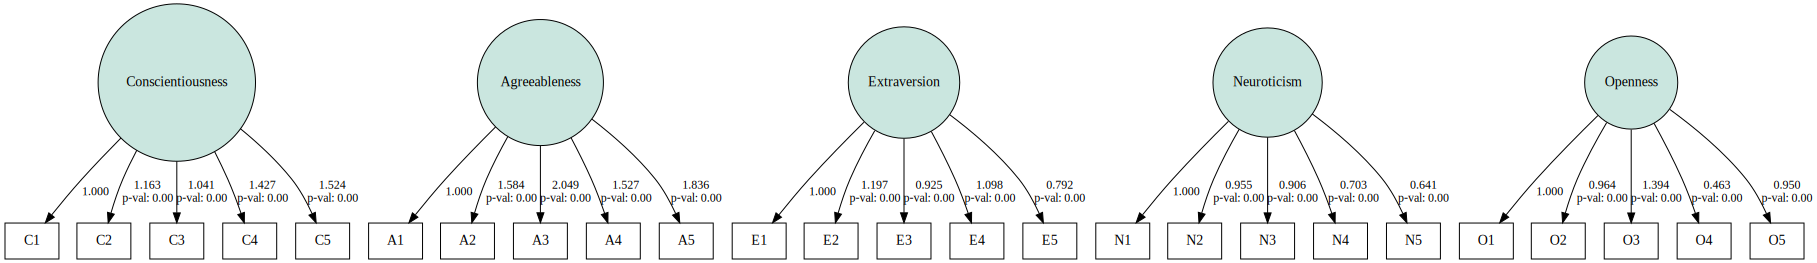

In [14]:
ff_viz = semplot(model, plot_exos = True, filename='five_factors.pdf')
ff_viz

# General distribution of traits

Let's do some quick visualization to see how much each factor varies:

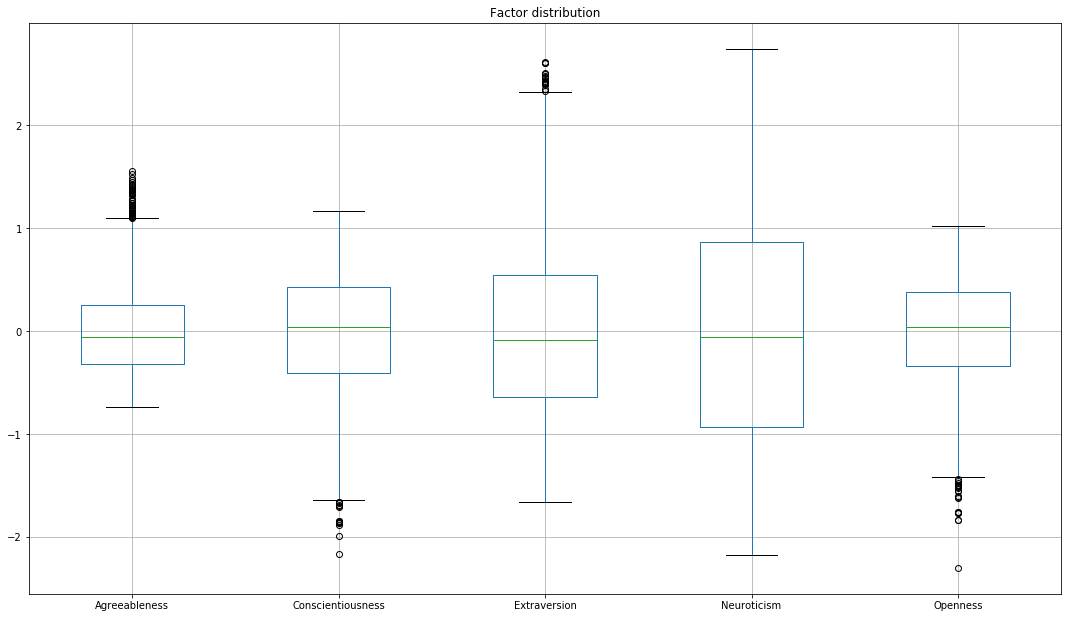

In [21]:
factors_dem = pd.concat([data, factors],  axis=1)
factors_dem.columns = data.columns.append(factors.columns)

factor_names = factors.columns

fig, axs = plt.subplots()
fig.set_size_inches(18.5, 10.5, forward=True)
factors_dem[factor_names].boxplot()
axs.set_title('Factor distribution');

These results make sense given the means and standard deviations we saw above.

Neuroticism seems to vary most among the respondents.

# Differences across demographics

I'm not entirely convinced the survey responses perfectly capture the facotrs of personality we are interested in and dataset is pretty small, but the it also has some interesting variables to cut on. Do any interesting patterns emerge?

### Gender

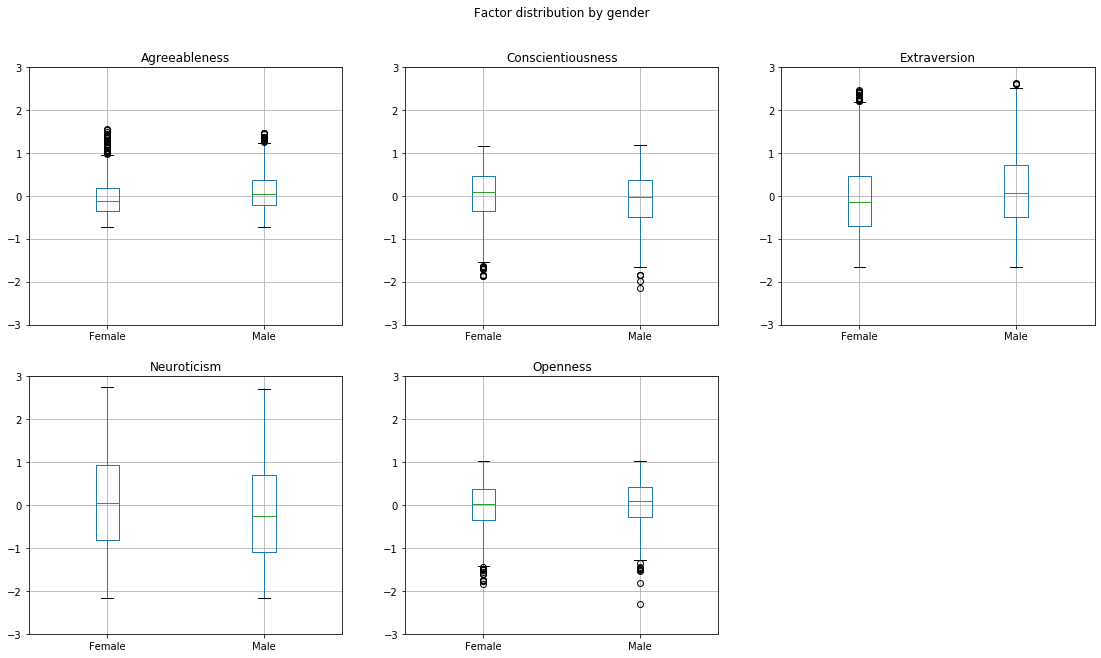

In [22]:
splitter = 'gender_2'

fig, axs = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5, forward=True)
for i, ax in enumerate(axs.flat):
    if i != 5:
        factors_dem.boxplot(column = factor_names[i], by=[splitter], ax = ax)
        ax.set_ylim([-3, 3])
        ax.set_xlabel('')
    else:
        ax.set_visible(False)
        
plt.suptitle('Factor distribution by gender');

In [23]:
pd.DataFrame(factors_dem[splitter].value_counts()).merge(
    round(factors_dem.groupby(splitter)[factor_names].agg([q25, q75]), 3),
    left_index = True,
    right_index = True)

C:\Users\mille\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,gender_2,"(Agreeableness, q25)","(Agreeableness, q75)","(Conscientiousness, q25)","(Conscientiousness, q75)","(Extraversion, q25)","(Extraversion, q75)","(Neuroticism, q25)","(Neuroticism, q75)","(Openness, q25)","(Openness, q75)"
Female,1881,-0.352,0.172,-0.350,0.468,-0.698,0.453,-0.813,0.926,-0.351,0.368
Male,919,-0.212,0.371,-0.494,0.355,-0.501,0.703,-1.095,0.687,-0.275,0.425


Based on an eyeball test, men in the dataset may index lower on Extraversion and Neuroticism.

### Education

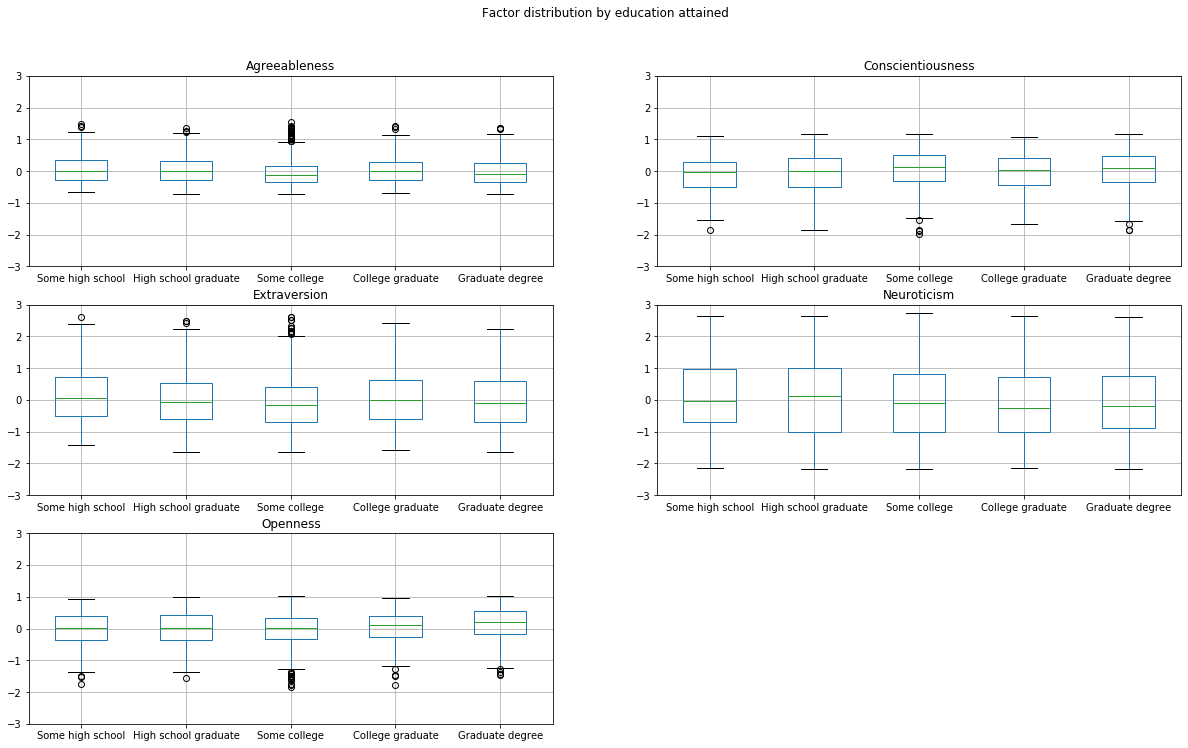

In [28]:
splitter = 'education_2'

fig, axs = plt.subplots(3,2)
fig.set_size_inches(20, 12, forward=True)
for i, ax in enumerate(axs.flat):
    if i != 5:
        factors_dem.boxplot(column = factor_names[i], by=[splitter], ax = ax)
        ax.set_ylim([-3, 3])
        ax.set_xlabel('')
    else:
        ax.set_visible(False)
        
plt.suptitle('Factor distribution by education attained');

In [19]:
pd.DataFrame(factors_dem[splitter].value_counts().sort_index()).merge(
    round(factors_dem.groupby(splitter)[factor_names].agg([q25, q75]), 3),
    left_index = True,
    right_index = True)

C:\Users\mille\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,education_2,"(Agreeableness, q25)","(Agreeableness, q75)","(Conscientiousness, q25)","(Conscientiousness, q75)","(Extraversion, q25)","(Extraversion, q75)","(Neuroticism, q25)","(Neuroticism, q75)","(Openness, q25)","(Openness, q75)"
Some high school,224,-0.338,0.283,-0.508,0.293,-0.713,0.511,-0.712,0.959,-0.358,0.386
High school graduate,292,-0.302,0.296,-0.498,0.427,-0.537,0.602,-1.024,1.011,-0.353,0.432
Some college,1249,-0.165,0.348,-0.304,0.502,-0.396,0.695,-1.003,0.817,-0.337,0.340
College graduate,394,-0.289,0.273,-0.435,0.401,-0.619,0.597,-1.010,0.719,-0.270,0.383
Graduate degree,418,-0.251,0.356,-0.356,0.471,-0.589,0.699,-0.896,0.741,-0.174,0.546


Another eyeball test: Conscientiousness and Openness may increase with education and Neuroticism may decrease with education.

### Age

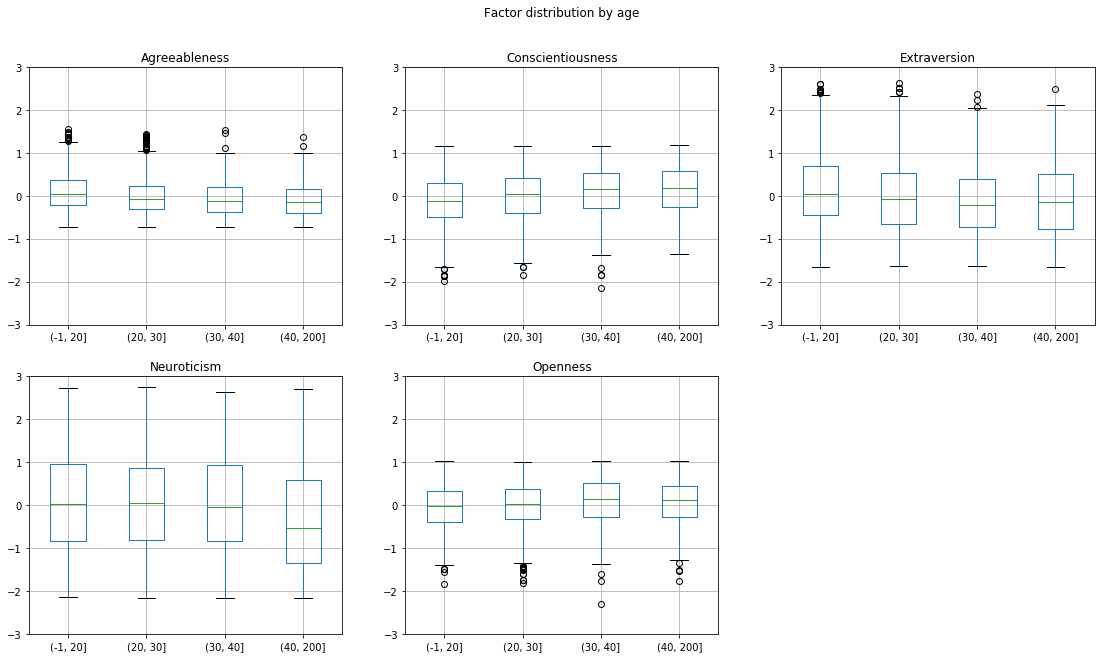

In [26]:
splitter = 'age_bin'

fig, axs = plt.subplots(2,3)
fig.set_size_inches(18.5, 10.5, forward=True)
for i, ax in enumerate(axs.flat):
    if i != 5:
        factors_dem.boxplot(column = factor_names[i], by=[splitter], ax = ax)
        ax.set_ylim([-3, 3])
        ax.set_xlabel('')
    else:
        ax.set_visible(False)
        
plt.suptitle('Factor distribution by age'.format(splitter));

In [21]:
pd.DataFrame(factors_dem[splitter].value_counts().sort_index()).merge(
    round(factors_dem.groupby(splitter)[factor_names].agg([q25, q75]), 3),
    left_index = True,
    right_index = True)

C:\Users\mille\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,age_bin,"(Agreeableness, q25)","(Agreeableness, q75)","(Conscientiousness, q25)","(Conscientiousness, q75)","(Extraversion, q25)","(Extraversion, q75)","(Neuroticism, q25)","(Neuroticism, q75)","(Openness, q25)","(Openness, q75)"
"(-1, 20]",774,-0.367,0.221,-0.497,0.297,-0.688,0.442,-0.838,0.953,-0.392,0.314
"(20, 30]",1047,-0.236,0.319,-0.410,0.401,-0.536,0.654,-0.818,0.866,-0.335,0.371
"(30, 40]",537,-0.196,0.373,-0.283,0.532,-0.384,0.730,-0.849,0.936,-0.281,0.502
"(40, 200]",442,-0.166,0.404,-0.263,0.580,-0.508,0.780,-1.351,0.573,-0.270,0.441


Final eyeball test: Agreeableness, Conscientiousness, Extraversion, and Openness may increase with age, and Neuroticism may decrease with age.

# Beyond univariate

It would be nice to have more information to control for differences across subjects and make more definite claims about the relationships between demographic variables and personality.

For now, let's turn to the work horse that is linear regression.

To regress on gender, age, and education, we should return to using the unprocessed data (i.e. not bucketed, not strings).

In [22]:
mr_desc ="""
Agreeableness, Conscientiousness, Extraversion, Neuroticism, Openness ~ gender + education + age
"""

mr = Model(mr_desc)
res_opt = mr.fit(factors_dem.dropna())
estimates = mr.inspect()

results = estimates[estimates.op=='~'].sort_values(['rval', 'lval'])[['lval', 'rval', 'Estimate', 'p-value']]

results['p-value'] = np.round(results['p-value'], 3)

### Gender

In [23]:
results[results.rval=='gender']

,lval,rval,Estimate,p-value
0,Agreeableness,gender,0.174357,0.00
3,Conscientiousness,gender,0.097157,0.00
6,Extraversion,gender,0.234908,0.00
9,Neuroticism,gender,0.231262,0.00
12,Openness,gender,-0.054675,0.02


I was too conservative with my first eyeball test. Females tend to index higher on all traits but Openness, where they index lower, in our dataset.

### Education

In [24]:
results[results.rval=='education']

,lval,rval,Estimate,p-value
1,Agreeableness,education,-0.000675,0.932
4,Conscientiousness,education,0.004393,0.693
7,Extraversion,education,0.003890,0.810
10,Neuroticism,education,-0.019603,0.392
13,Openness,education,0.042293,0.000


Openness is the only trait that meaningfully changes with education. As one becomes more educated, they may see Openness subtly increase. 

### Age

In [25]:
results[results.rval=='age']

,lval,rval,Estimate,p-value
2,Agreeableness,age,0.004181,0.000
5,Conscientiousness,age,0.005645,0.000
8,Extraversion,age,0.005322,0.002
11,Neuroticism,age,-0.011854,0.000
14,Openness,age,0.002518,0.019


As one ages, they might start indexing a bit higher on all traits besides Neuroticism. Here they might expect to index lower over time. 

# A caveat

In [26]:
for factor in factor_names:
    if factor == 'Agreeableness':
        data_2 = factors_dem[['gender', 'education', 'age', factor]].dropna()

        X = sm.add_constant(data_2[['gender', 'education', 'age']])
        y = data_2[factor]

        model = sm.OLS(y, X)
        results = model.fit()
        print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          Agreeableness   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     40.94
Date:                Wed, 22 Dec 2021   Prob (F-statistic):           9.51e-26
Time:                        15:42:24   Log-Likelihood:                -1150.5
No. Observations:                2236   AIC:                             2309.
Df Residuals:                    2232   BIC:                             2332.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2203      0.034     -6.538      0.0

Above is a lengthier set of regression results. You'll notice, for Agreeableness, individual significance is present where we saw it before (i.e. statistically significant relationships with gender and age.)

We also observe joint significance based on the results of the F test.

However, effect sizes are relatively small and $R^2$ leaves A LOT of room for improvement. Personality varies across individuals and variables outside of the demographic variables available in our dataset (both nature and nurture) will influence where people fall along each factor's continuum. Given this information and a small sample size, we might want to be hesitant about applying our findings to the broader population.

Nonetheless, exploring semopy with the five-factor model has been fun!